<h1> Data Wrangling </h1>
<h3> Import datasets </h3>

In [1]:
#load required library
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
train_data=pd.read_csv('C:/Uni/MSA/train.csv')
test_data=pd.read_csv("C:/Uni/MSA/test.csv")

<h3>Data Exploration</h3>
<p> Explore dataset and visualize the most common 2-word phrase to see the main topic of the book </p>

In [3]:
train_data.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


<p>We are going to use excerpt to predict target, i.e. the readibility of the book which indicates how hard it is to read. The other variables are not suitable for the task </p>

<h3>Data Preparation </h3>
<p>Vectorize the word, or convert words into interger number so that the machine can understand and work with it </p>

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=2000, lowercase=True)
X=vectorizer.fit_transform(train_data['excerpt'].values)
X

<2834x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 106714 stored elements in Compressed Sparse Row format>

In [5]:
y=train_data.loc[:, 'target']

<h5>Split the train data to train and test dataset to test model efficiency before actually applying to the test dataset </h5>

In [6]:
from sklearn.model_selection import train_test_split
#split to train and test set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(train_data['excerpt'][0])

<p>Visualize the vectorization </p>

<AxesSubplot:xlabel='Numbers representing words after vectorization', ylabel='Frequency of usage'>

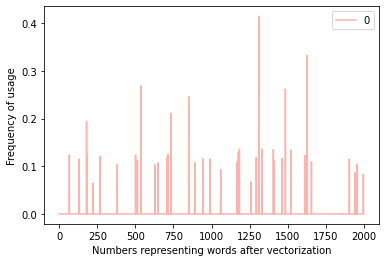

In [8]:
pd.DataFrame(vectorizer.transform(train_data['excerpt'][[0]] ).toarray()).T.plot(xlabel='Numbers representing words after vectorization',
                                                                                ylabel='Frequency of usage', colormap='Pastel1')

<p>Plot top most common 2-words to see the topic </p>

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
def ngrams(n, title, loc):
    """A Function to plot most common ngrams"""
    fig, ax = plt.subplots(figsize=(18, 8))

    new = train_data.excerpt.str.split()
    new = new.values.tolist()
    corpus = [word.lower() for i in new for word in i if word.lower()]
    
    def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
                          for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

    top_n_bigrams = _get_top_ngram(train_data.excerpt, n)[:15]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)  

    
    for n, i in enumerate(x):    
            ax.text(y[n]-loc, 
            n, #Y location
            s=f'{round(y[n],3)}', 
            va='center', 
            ha='right', 
            color='white', 
            fontsize=8,
            bbox=dict(boxstyle='square',facecolor='black', alpha=0.5))

    fig.suptitle(title, fontsize=24, va='baseline')
    sns.despine()
    plt.xticks([])
    fig.patch.set_facecolor('#cffff7')
    ax.patch.set_facecolor('#f2ffff')
    plt.show()

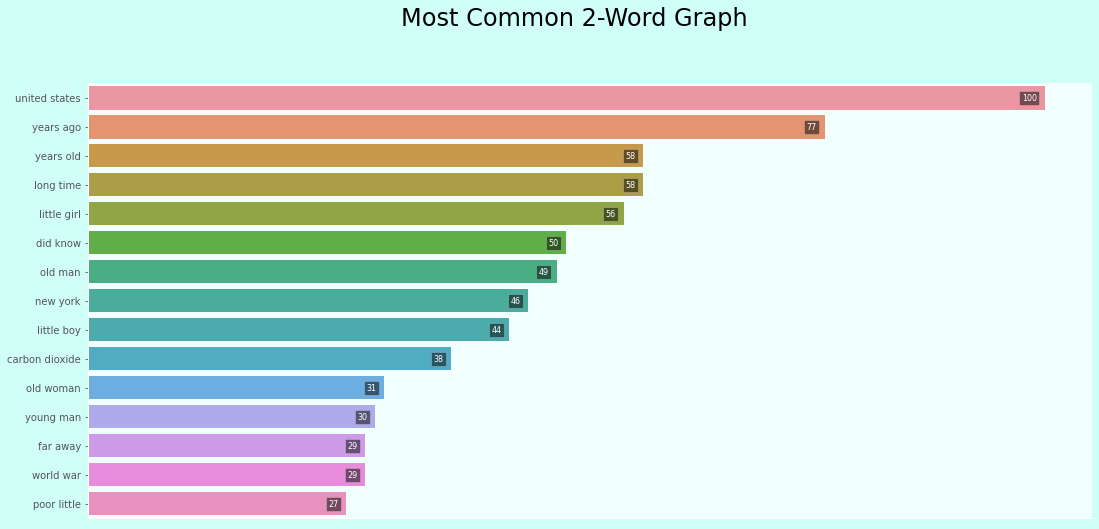

In [10]:
ngrams(2, 'Most Common 2-Word Graph', 0.8)

In [11]:
X_train.toarray().shape

(2267, 2000)

<h1>Data Modeling</h1>
<p>We will explore different models, apply them in the test data to evaluate which model provides the best results based on their scores</p>
<h3>Neural Network - Multi-layer Perceptron Regressor</h3>

In [12]:
from sklearn.neural_network import MLPRegressor
import xgboost as xg
from sklearn.ensemble import RandomForestRegressor

#data modelling - MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(512,1024,1024,512 ))

#model fitting and evaluation
regr.fit(X_train,y_train)
y_pred = regr.predict(X_val)
regr.score(X_val,y_val)

0.4304233295929897

In [13]:
#Calculate Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(y_val,y_pred)
math.sqrt(mse)

0.7722671327222546

<h3>XGBoost - Extreme Gradient Boost</h3>

In [16]:
#data modelling - XGBoost
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 1234)
  
# Fitting the model
xgb_r.fit(X_train, y_train)
y_predXG = xgb_r.predict(X_val)

#Evaluating model with RMSE
mseXG = mean_squared_error(y_val,y_predXG)
math.sqrt(mseXG)

[09:28:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.


0.8699365726318169

<h3>Random Forest Regressor </h3>

In [18]:
regrRandomForest = RandomForestRegressor()

#Fitting model
regrRandomForest.fit(X_train,y_train)
y_predRF = regrRandomForest.predict(X_val)

#evaluate model
regrRandomForest.score(X_val,y_val)

0.35085171156336836

In [19]:
#Calculate RMSE
mseRF = mean_squared_error(y_val,y_predRF)
math.sqrt(mseRF)

0.8244482752967623

<p> As RMSE of the Multi-layer Perceptron is smallest, we will use that model to use with our scrapped book data </p>

In [20]:
import pickle

filename = 'mlpregressor.pkl'
pickle.dump(regr, open(filename, 'wb'))

<h1>Cleaning book data</h1>

In [32]:
data=pd.read_csv('C:/Uni/MSA/2021 data science/Book_download.csv')

data['book_chapter']=data['book_chapter'].str.replace('\\n', ' ')
data['book_chapter']=data['book_chapter'].str.replace('\\r', ' ')
data['book_chapter']=data['book_chapter'].str.lower()
data['book']=data['book'].str.replace('\\n', ' ')
data['book']=data['book'].str.replace('\\r', ' ')

data=data.dropna(subset=['book_chapter'])
data.tail()

<ipython-input-32-c75b400a299b>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  data['book_chapter']=data['book_chapter'].str.replace('\\n', ' ')
<ipython-input-32-c75b400a299b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  data['book_chapter']=data['book_chapter'].str.replace('\\r', ' ')
<ipython-input-32-c75b400a299b>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  data['book']=data['book'].str.replace('\\n', ' ')
<ipython-input-32-c75b400a299b>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data['book']=data['book'].str.replace('\\r', ' ')


,Unnamed: 0,book,book_download_link,book_chapter
45,45,Le Morte D’Arthur,https://www.gutenberg.org/ebooks/1251.html.images,bibliographical note the morte d’arthur was ...
46,46,THE ENTIRE ORIGINAL MAUPASSANT SHORT STORIES,https://www.gutenberg.org/ebooks/3090.html.images,volume i.
47,47,MANIFESTO OF THE COMMUNIST PARTY,https://www.gutenberg.org/ebooks/61.html.noimages,*** start of this project gutenberg ebook the ...
48,48,Notes from the Underground,https://www.gutenberg.org/ebooks/600.html.images,*the author of the diary and the diary itself ...
49,49,The King James Version of the Bible,https://www.gutenberg.org/ebooks/10.html.images,the old testament of the king james version ...


In [33]:
X_test=vectorizer.fit_transform(data['book_chapter'].values)

y_test = regr.predict(X_test)


In [34]:
df = pd.DataFrame({'Book':data['book'].values, 'target': y_test})
# Put into .csv file
df.to_csv('book-submission.csv', index=False)